In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/"Colab Notebooks"/"AN2DL"/"HW1"

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/AN2DL/HW1


In [ ]:
%ls

 FT116MobileNetV2WithAugWith3HidWithDropout-76-LessOverFitting/
 FT125MobileNetV2WithAug-81-LessOverFitting/
 FT125MobileNetV2WithAug-83-LessOverFitting/
 FT125MobileNetV2WithAugWith1Hid1BN1Dropout-85-LessOverFitting/
 FT125MobileNetV2WithAugWith2Hid-84-LessOverFitting/
 FT125MobileNetV2WithAugWith2Split-84-LessOverFitting/
 FT125MobileNetV2WithoutAug/
 FTMobileNetV2WithoutAug/
 MobileNetV2.ipynb
 MobileNetV2WithFT116-allEpoches/
 MobileNetV2WithFT125-allEpoches/
 MobileNetV2WithFT125With1Den-allEpoches/
 MobileNetV2WithFT125With2Den2BN2Drop-allEpoches/
 MobileNetV2WithFT125With2Den-allEpoches/
 MobileNetV2WithoutFT-allEpoches/
 MobileNetV2WithoutFTAllOn-allEpoches/
 model.png
 public_data.npz
 Saved-MobileNetV2WithFT116-0.81/
 Saved-MobileNetV2WithFT116.csv
 Saved-MobileNetV2WithFT125-0.78/
 Saved-MobileNetV2WithFT125.csv
 Saved-MobileNetV2WithFT125With1Den-0.79/
 Saved-MobileNetV2WithFT125With1Den.csv
 Saved-MobileNetV2WithFT125With2Den-0.79/
 Saved-MobileNetV2WithFT125With2Den2BN2Dr

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

### Load data

In [ ]:
leaves = np.load('public_data.npz', allow_pickle=True)

# storing the data
# features (training set + validation set)
X_default = leaves['data']
# labels (training set + validation set)
y_default = leaves['labels']

labels = {0: 'healthy', 1:'unhealthy'}

In [ ]:
# 5200 RGB pics with size 96x96
print(X_default.shape)
print(y_default.shape)

(5200, 96, 96, 3)
(5200,)


In [ ]:
# # create more images
# preprocessing = tf.keras.Sequential([
#     tfkl.RandomBrightness(0.2, value_range=(0,1)),
#     tfkl.RandomTranslation(0.2,0.2),
#     tfkl.RandomContrast(0.75),
#     tfkl.RandomZoom(0.2),
#     tfkl.RandomRotation(0.5),
# ], name='preprocessing')

# unique, counts = np.unique(y_default, return_counts=True)
# label_difference = abs(counts[0]-counts[1])

# unhealthy_indices = np.where(y_default == 'unhealthy')[0]

# selected_indices = np.random.choice(unhealthy_indices, label_difference, replace=False)
# selected_images = X_default[selected_indices] / 255.0
# additional_unhealthy = np.full(label_difference, 'unhealthy')

# processed_images = np.array([preprocessing(image).numpy() for image in selected_images])

# X_moreData = np.concatenate((X_default, (processed_images * 255).astype(np.uint8)), axis=0)
# y_moreData = np.concatenate((y_default, additional_unhealthy), axis=0)

# print(X_moreData.shape)
# print(y_moreData.shape)

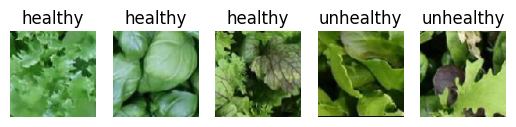

In [ ]:
# Display 5 images
num_samples = 5
# randomly select 5 pics to display with no replications
sample_indices = np.random.choice(len(X_default), num_samples, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)

    # Normalize the image data to the range [0, 1]
    normalized_image = X_default[idx] / 255.0  # If your original pixel values are in [0, 255]

    plt.imshow(normalized_image)
    plt.title(f'{y_default[idx]}')
    plt.axis('off')

plt.show()

In [ ]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
# print(pd.DataFrame(y, columns=['class'])['class'].value_counts())
print(pd.Series(y_default).value_counts())

Counting occurrences of target classes:
healthy      3199
unhealthy    2001
dtype: int64


### Process data

**Label encoding** assigns a unique integer to each category in the categorical array. This method is suitable for ordinal categorical data where there's an inherent order in the categories.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Sample categorical data
# categorical_data = ["healthy", "unhealty"]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical data
y = label_encoder.fit_transform(y_default)

# print(y_train_val)
print(pd.Series(y).value_counts())
print("-------")
print(y.shape)
# healthy -> 0
# unhealthy -> 1

0    3199
1    2001
dtype: int64
-------
(5200,)


In [ ]:
# outlier detection function
def outlier(x):
    return (np.all(x==X_default[58]) or np.all(x==X_default[412]))

# Identify non-outlier indices
non_outlier_indices = ~np.array([outlier(x) for x in X_default])

outlier_indices = np.array([outlier(x) for x in X_default])

outliers = X_default[outlier_indices]

# Create X and y arrays without outliers
X_default = X_default[non_outlier_indices]
y = y[non_outlier_indices]

In [ ]:
# Normalize data to the range [0, 1]
# X = (X_default / 255).astype('float32')
X = X_default

# # Convert labels to categorical format using one-hot encoding
# y = tfk.utils.to_categorical(y)

print(X.shape)
print(y.shape)

(5004, 96, 96, 3)
(5004,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Find indices for each class
indices_class_0 = np.where(y == 0)[0]
indices_class_1 = np.where(y == 1)[0]

# Split each class into train and test
X_train_class_0, X_test_class_0, y_train_class_0, y_test_class_0 = train_test_split(
    X[indices_class_0], y[indices_class_0], test_size=500, random_state=seed
)

X_train_class_1, X_test_class_1, y_train_class_1, y_test_class_1 = train_test_split(
    X[indices_class_1], y[indices_class_1], test_size=500, random_state=seed
)

# More Balanced training set
X_val_test = shuffle(np.concatenate([X_test_class_0, X_test_class_1], axis=0), random_state = seed)
y_val_test = shuffle(np.concatenate([y_test_class_0, y_test_class_1], axis=0), random_state = seed)
X_train = np.concatenate([X_train_class_0, X_train_class_1], axis=0)
y_train = np.concatenate([y_train_class_0, y_train_class_1], axis=0)

In [ ]:
# Split val and Test equally
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state=seed, shuffle = True)

In [ ]:
print(f"train \n{pd.Series(y_train).value_counts()}")
print(f"val\n{pd.Series(y_val).value_counts()}")
print(f"test\n{pd.Series(y_test).value_counts()}")

train 
0    2601
1    1403
dtype: int64
val
1    250
0    250
dtype: int64
test
1    250
0    250
dtype: int64


In [ ]:
#Randomly choose images from class 1 (unhealthy) and apply data augmentation on it

unique, counts = np.unique(y_train, return_counts=True)
label_difference = abs(counts[0]-counts[1])
# label_difference = 600

unhealthy_indices = np.where(y_train == 1)[0]

selected_indices = np.random.choice(unhealthy_indices, label_difference, replace=False)
selected_images = X[selected_indices]

# augmentation techniques
fs = [tf.image.flip_left_right, tf.image.flip_up_down, tf.image.transpose]

processed_images = np.array([np.random.choice(fs)(image) for image in selected_images])

additional_unhealthy = np.full(label_difference, '1')

X_train = shuffle(np.concatenate((X_train, processed_images), axis=0), random_state = seed)
y_train = shuffle(np.concatenate((y_train, additional_unhealthy), axis=0), random_state = seed)

In [ ]:
print(f"train \n{pd.Series(y_train).value_counts()}")

train 
0    2601
1    2601
dtype: int64


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

In [ ]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (5202, 96, 96, 3), y_train shape: (5202, 2)
X_val shape: (500, 96, 96, 3), y_val shape: (500, 2)
X_test shape: (500, 96, 96, 3), y_test shape: (500, 2)


In [ ]:
# # Split data into training, validation and test sets, maintaining class distribution
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# # Print the shapes of the resulting datasets
# print("Training Data Shape:", X_train.shape)
# print("Training Label Shape:", y_train.shape)
# print("Validation Data Shape:", X_val.shape)
# print("Validation Label Shape:", y_val.shape)
# print("Test Data Shape:", X_test.shape)
# print("Test Label Shape:", y_test.shape)

In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
# np.argmax returns the index of the maximal value in the array
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: [1. 0.]
"Default" label: 0


### Parameters settings

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model -> size * channels
output_shape = y_train.shape[1]  # Output shape for the model -> #classes
batch_size = 64                  # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 64
Input Shape: (96, 96, 3)
Output Shape: 2


## Only train one of them at a time (all the blocks have the complete training process inside)

### MobileNetV2 trained from 125th layer with 2 Dense layers & 2 Batch Normalization layers & 2 Dropout layers

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

In [ ]:
# train all the weights
modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')

# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# dense layers with Batch Normalization and dropout
hidden1 = tfkl.Dense(units = 256,
                     kernel_regularizer = tfk.regularizers.l2(2e-5),
                     kernel_initializer = tfk.initializers.HeUniform(seed=seed),
                     name="hidden1")(process)
bn1 = tfkl.BatchNormalization()(hidden1)
dropout1 = tfkl.Dropout(0.3, name="dropou1")(bn1)
act1 = tfkl.Activation('relu', name="activation1")(dropout1)

hidden2 = tfkl.Dense(units = 128,
                     kernel_regularizer = tfk.regularizers.l2(2e-5),
                     kernel_initializer = tfk.initializers.HeUniform(seed=seed),
                     name="hidden2")(act1)
bn2 = tfkl.BatchNormalization()(hidden2)
dropout2 = tfkl.Dropout(0.3, name="dropou2")(bn2)
act2 = tfkl.Activation('relu', name="activation2")(dropout2)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(act2)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# Freeze the weights of first N layers, e.g., until the 133rd one
# start from block_14
N = 125
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_11 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_exp

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithFT125WithAugWith2Dense.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 15s 59ms/step - loss: 0.9150 - accuracy: 0.5144 - precision_10: 0.5144 - recall_10: 0.5144 - f1_score: 0.5142 - val_loss: 0.7418 - val_accuracy: 0.5500 - val_precision_10: 0.5500 - val_recall_10: 0.5500 - val_f1_score: 0.5495
Epoch 2/200
82/82 [==============================] - 4s 46ms/step - loss: 0.8774 - accuracy: 0.5208 - precision_10: 0.5208 - recall_10: 0.5208 - f1_score: 0.5206 - val_loss: 0.7287 - val_accuracy: 0.5660 - val_precision_10: 0.5660 - val_recall_10: 0.5660 - val_f1_score: 0.5659
Epoch 3/200
82/82 [==============================] - 4s 44ms/step - loss: 0.8553 - accuracy: 0.5490 - precision_10: 0.5490 - recall_10: 0.5490 - f1_score: 0.5489 - val_loss: 0.7147 - val_accuracy: 0.5940 - val_precision_10: 0.5940 - val_recall_10: 0.5940 - val_f1_score: 0.5935
Epoch 4/200
82/82 [==============================] - 3s 42ms/step - loss: 0.8439 - accuracy: 0.5484 - precision_10: 0.5484 - recall_10: 0.5484 - f1_score: 0.5484 - v

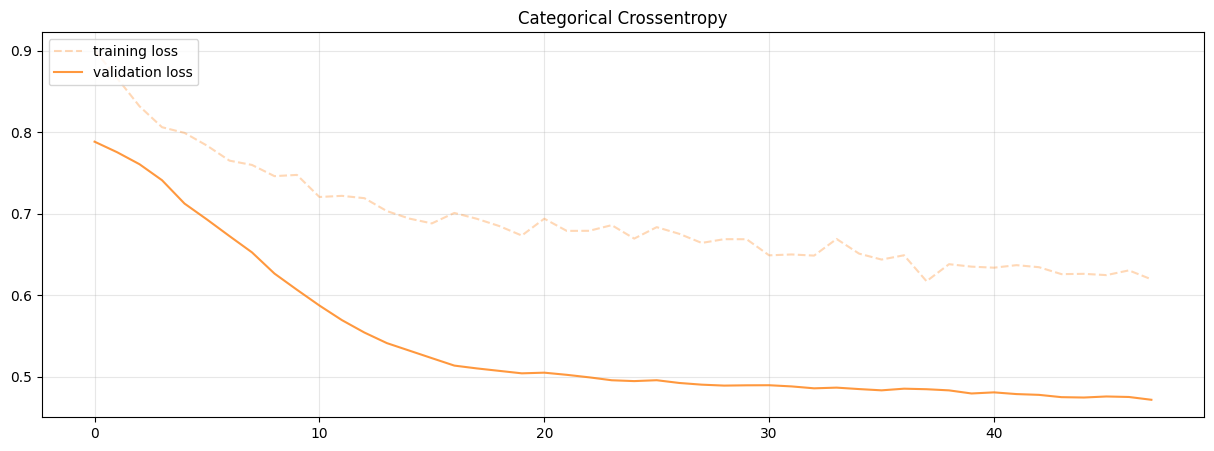

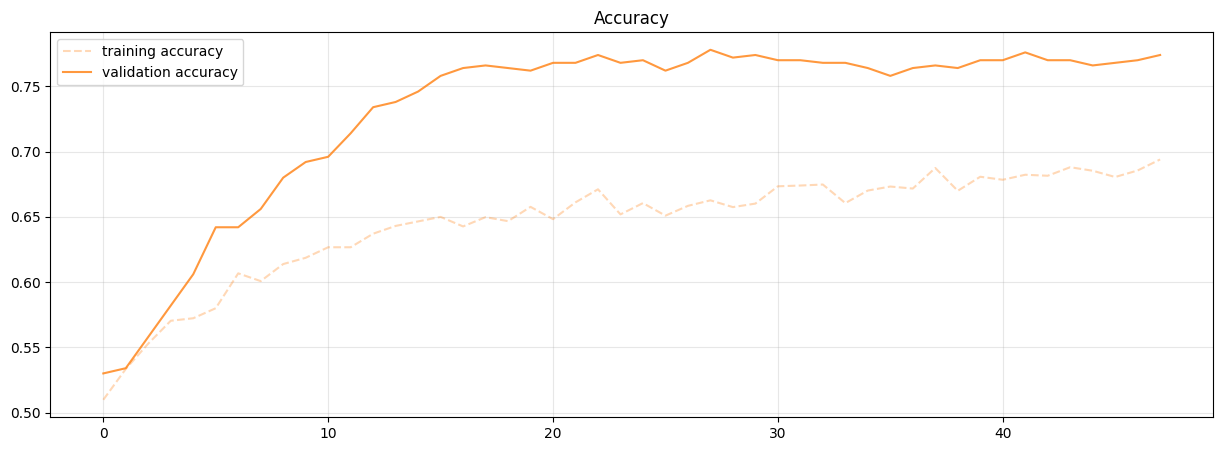

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.8020
0.8019999861717224


In [ ]:
model.save("Sec-Saved-FT125MobileNetV2WithAugWith2Dense")
del model

### MobileNetV2 trained from 116th layer with 2 Dense layers & 2 Batch Normalization layers & 2 Dropout layers

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# train all the weights
modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')

# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# dense layers with Batch Normalization and dropout
hidden1 = tfkl.Dense(units = 256,
                     kernel_regularizer = tfk.regularizers.l2(2e-5),
                     kernel_initializer = tfk.initializers.HeUniform(seed=seed),
                     name="hidden1")(process)
bn1 = tfkl.BatchNormalization()(hidden1)
dropout1 = tfkl.Dropout(0.3, name="dropou1")(bn1)
act1 = tfkl.Activation('relu', name="activation1")(dropout1)

hidden2 = tfkl.Dense(units = 128,
                     kernel_regularizer = tfk.regularizers.l2(2e-5),
                     kernel_initializer = tfk.initializers.HeUniform(seed=seed),
                     name="hidden2")(act1)
bn2 = tfkl.BatchNormalization()(hidden2)
dropout2 = tfkl.Dropout(0.3, name="dropou2")(bn2)
act2 = tfkl.Activation('relu', name="activation2")(dropout2)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(act2)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# Freeze the weights of first N layers, e.g., until the 133rd one
# start from block_13
N = 116
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithFT116WithAugWith2Dense.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 31s 89ms/step - loss: 0.9900 - accuracy: 0.5167 - precision: 0.5167 - recall: 0.5167 - f1_score: 0.4840 - val_loss: 0.8363 - val_accuracy: 0.5200 - val_precision: 0.5200 - val_recall: 0.5200 - val_f1_score: 0.4697
Epoch 2/200
82/82 [==============================] - 4s 47ms/step - loss: 0.9300 - accuracy: 0.5327 - precision: 0.5327 - recall: 0.5327 - f1_score: 0.5040 - val_loss: 0.7885 - val_accuracy: 0.5380 - val_precision: 0.5380 - val_recall: 0.5380 - val_f1_score: 0.5131
Epoch 3/200
82/82 [==============================] - 4s 45ms/step - loss: 0.9270 - accuracy: 0.5350 - precision: 0.5350 - recall: 0.5350 - f1_score: 0.5110 - val_loss: 0.7659 - val_accuracy: 0.5600 - val_precision: 0.5600 - val_recall: 0.5600 - val_f1_score: 0.5376
Epoch 4/200
82/82 [==============================] - 4s 44ms/step - loss: 0.8797 - accuracy: 0.5534 - precision: 0.5534 - recall: 0.5534 - f1_score: 0.5331 - val_loss: 0.7367 - val_accuracy: 0.5940 - v

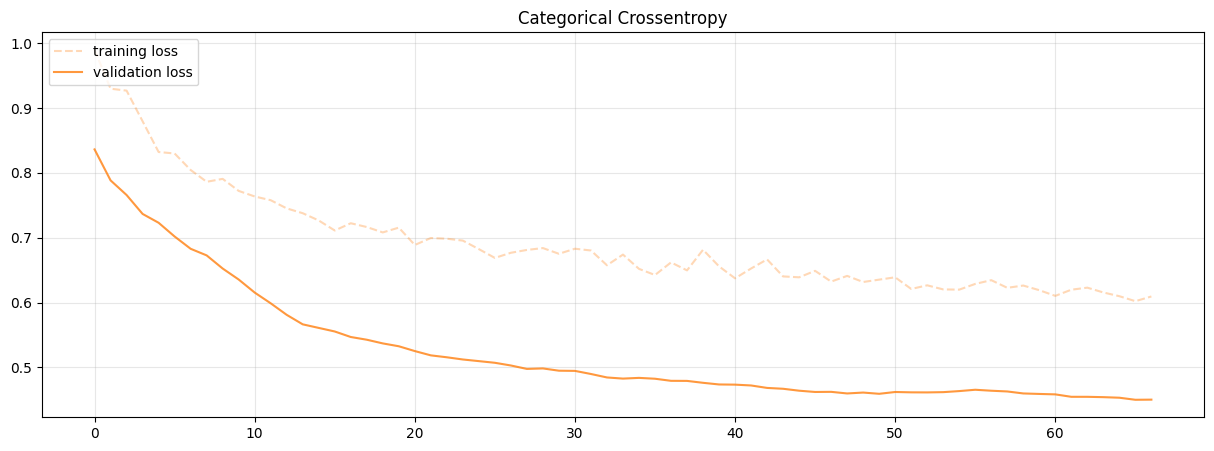

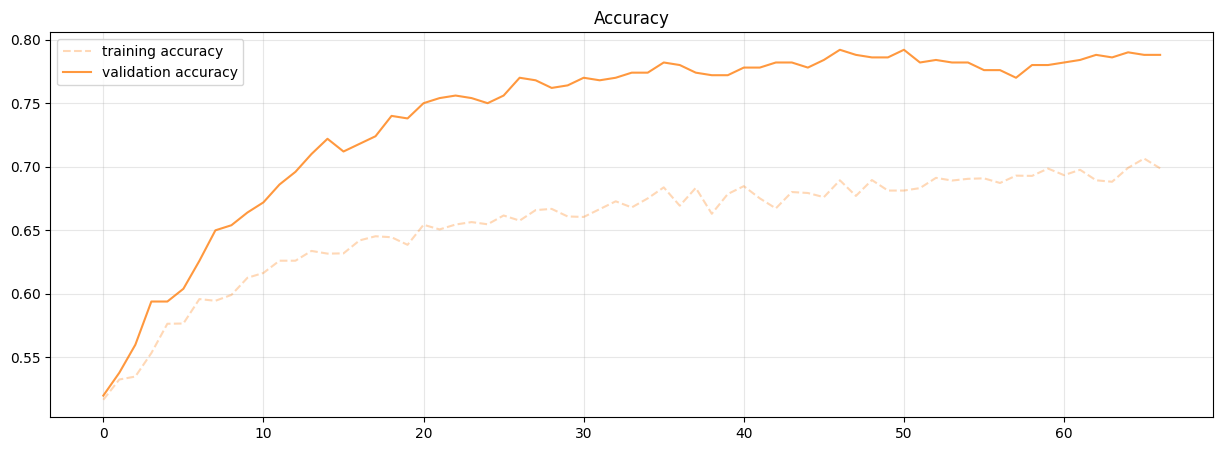

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.8360
0.8360000252723694


In [ ]:
model.save("Sec-Saved-FT116MobileNetV2WithAugWith2Dense")
del model

### MobileNetV2 trained from 125th layer with 1 Dense layer & 1 Batch Normalization layer & 1 Dropout layer

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

In [ ]:
# train all the weights
modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')


# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# dense layers with Batch Normalization and dropout
hidden1 = tfkl.Dense(units = 256,
                     kernel_regularizer = tfk.regularizers.l2(2e-5),
                     kernel_initializer = tfk.initializers.HeUniform(seed=seed),
                     name="hidden1")(process)
bn1 = tfkl.BatchNormalization()(hidden1)
dropout1 = tfkl.Dropout(0.3, name="dropou1")(bn1)
act1 = tfkl.Activation('relu', name="activation1")(dropout1)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(act1)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# Freeze the weights of first N layers, e.g., until the 133rd one
# start from block_14
N = 125
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_2 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithFT125WithAugWith1Dense.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 14s 57ms/step - loss: 0.9065 - accuracy: 0.5342 - precision_1: 0.5342 - recall_1: 0.5342 - f1_score: 0.5295 - val_loss: 0.8343 - val_accuracy: 0.5420 - val_precision_1: 0.5420 - val_recall_1: 0.5420 - val_f1_score: 0.5248
Epoch 2/200
82/82 [==============================] - 3s 40ms/step - loss: 0.8658 - accuracy: 0.5538 - precision_1: 0.5538 - recall_1: 0.5538 - f1_score: 0.5504 - val_loss: 0.7697 - val_accuracy: 0.5980 - val_precision_1: 0.5980 - val_recall_1: 0.5980 - val_f1_score: 0.5976
Epoch 3/200
82/82 [==============================] - 4s 46ms/step - loss: 0.8164 - accuracy: 0.5888 - precision_1: 0.5888 - recall_1: 0.5888 - f1_score: 0.5869 - val_loss: 0.7427 - val_accuracy: 0.6040 - val_precision_1: 0.6040 - val_recall_1: 0.6040 - val_f1_score: 0.6026
Epoch 4/200
82/82 [==============================] - 3s 42ms/step - loss: 0.8001 - accuracy: 0.5894 - precision_1: 0.5894 - recall_1: 0.5894 - f1_score: 0.5879 - val_loss: 0.714

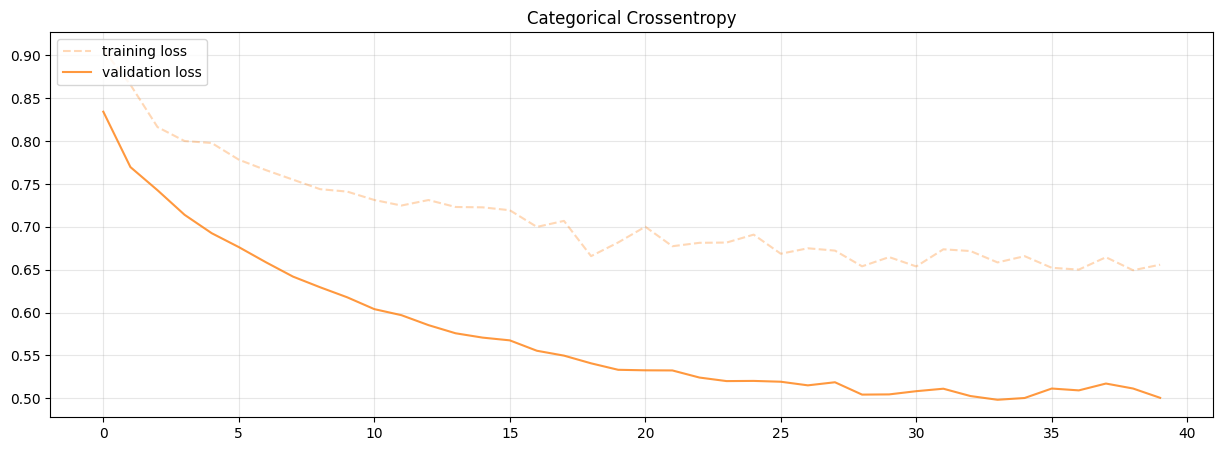

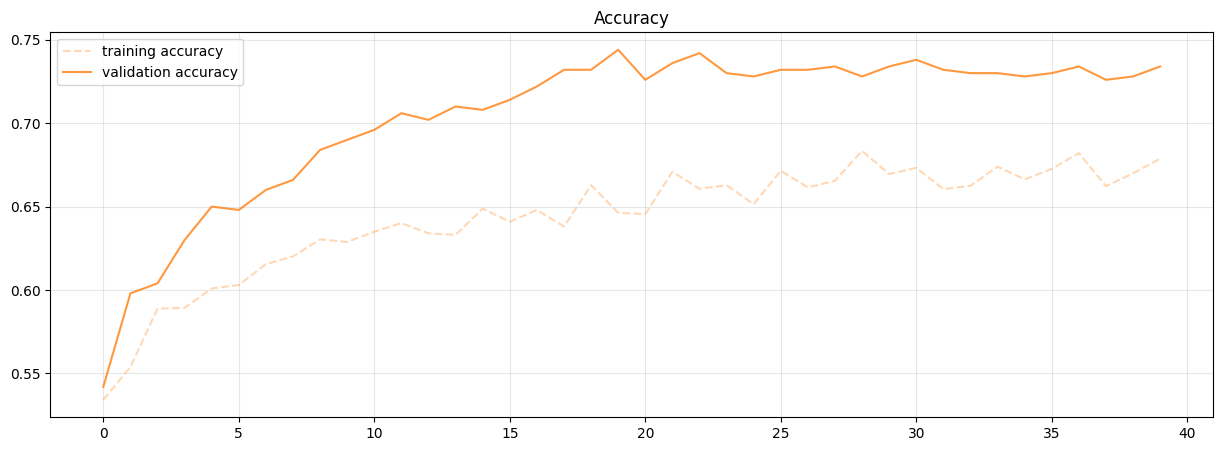

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.7500
0.75


In [ ]:
model.save("Sec-Saved-FT125MobileNetV2WithAugWith1Dense")
del model

### MobileNetV2 trained from 116th layer without MLP structure

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

In [ ]:
# train all the weights
modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')

# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(process)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# Freeze the weights of first N layers, e.g., until the 133rd one
# start from block_13
N = 116
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_3 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithFT116WithAug.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 15s 58ms/step - loss: 0.8143 - accuracy: 0.5442 - precision_2: 0.5442 - recall_2: 0.5442 - f1_score: 0.5344 - val_loss: 0.7168 - val_accuracy: 0.6140 - val_precision_2: 0.6140 - val_recall_2: 0.6140 - val_f1_score: 0.6099
Epoch 2/200
82/82 [==============================] - 3s 42ms/step - loss: 0.7276 - accuracy: 0.5913 - precision_2: 0.5913 - recall_2: 0.5913 - f1_score: 0.5901 - val_loss: 0.6716 - val_accuracy: 0.6420 - val_precision_2: 0.6420 - val_recall_2: 0.6420 - val_f1_score: 0.6404
Epoch 3/200
82/82 [==============================] - 4s 47ms/step - loss: 0.6869 - accuracy: 0.6311 - precision_2: 0.6311 - recall_2: 0.6311 - f1_score: 0.6311 - val_loss: 0.6423 - val_accuracy: 0.6660 - val_precision_2: 0.6660 - val_recall_2: 0.6660 - val_f1_score: 0.6652
Epoch 4/200
82/82 [==============================] - 4s 45ms/step - loss: 0.6767 - accuracy: 0.6357 - precision_2: 0.6357 - recall_2: 0.6357 - f1_score: 0.6356 - val_loss: 0.625

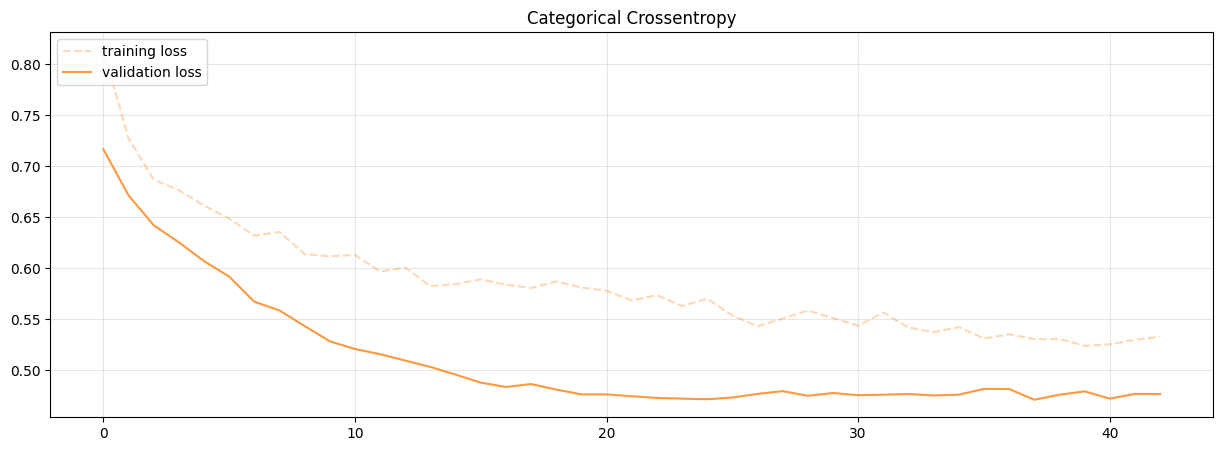

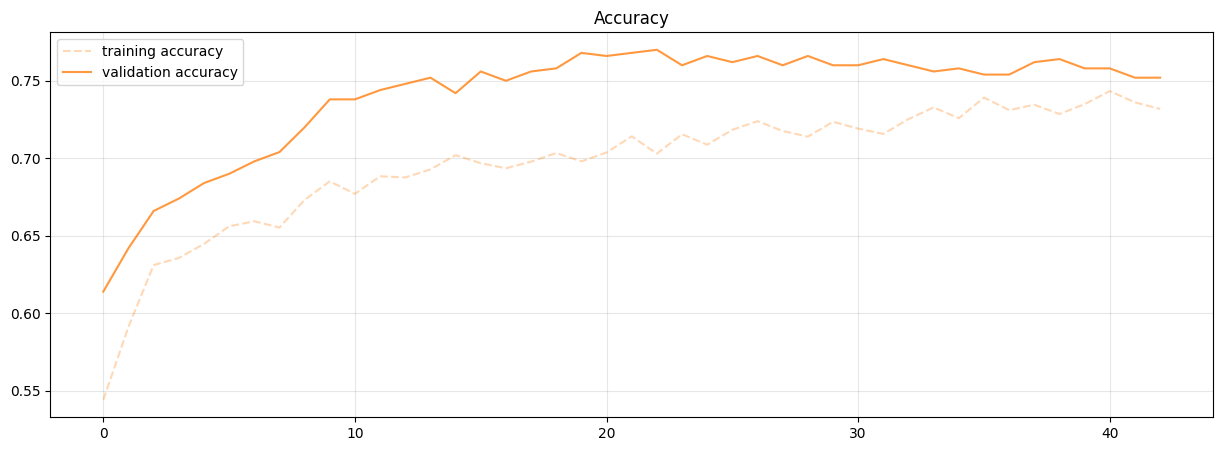

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.8220
0.8220000267028809


In [ ]:
model.save("Sec-Saved-FT116MobileNetV2WithAug")
del model

### MobileNetV2 trained from 125th layer without MLP structure

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

In [ ]:
# train all the weights
modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')


# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(process)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# Freeze the weights of first N layers, e.g., until the 133rd one
# start from block_14
N = 125
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_4 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithFT125WithAug.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 12s 55ms/step - loss: 0.8273 - accuracy: 0.5338 - precision_3: 0.5338 - recall_3: 0.5338 - f1_score: 0.5338 - val_loss: 1.0478 - val_accuracy: 0.4720 - val_precision_3: 0.4720 - val_recall_3: 0.4720 - val_f1_score: 0.4048
Epoch 2/200
82/82 [==============================] - 3s 40ms/step - loss: 0.7617 - accuracy: 0.5702 - precision_3: 0.5702 - recall_3: 0.5702 - f1_score: 0.5701 - val_loss: 0.9058 - val_accuracy: 0.4980 - val_precision_3: 0.4980 - val_recall_3: 0.4980 - val_f1_score: 0.4533
Epoch 3/200
82/82 [==============================] - 4s 45ms/step - loss: 0.7142 - accuracy: 0.6021 - precision_3: 0.6021 - recall_3: 0.6021 - f1_score: 0.6021 - val_loss: 0.8406 - val_accuracy: 0.5340 - val_precision_3: 0.5340 - val_recall_3: 0.5340 - val_f1_score: 0.5008
Epoch 4/200
82/82 [==============================] - 4s 43ms/step - loss: 0.7013 - accuracy: 0.6107 - precision_3: 0.6107 - recall_3: 0.6107 - f1_score: 0.6107 - val_loss: 0.789

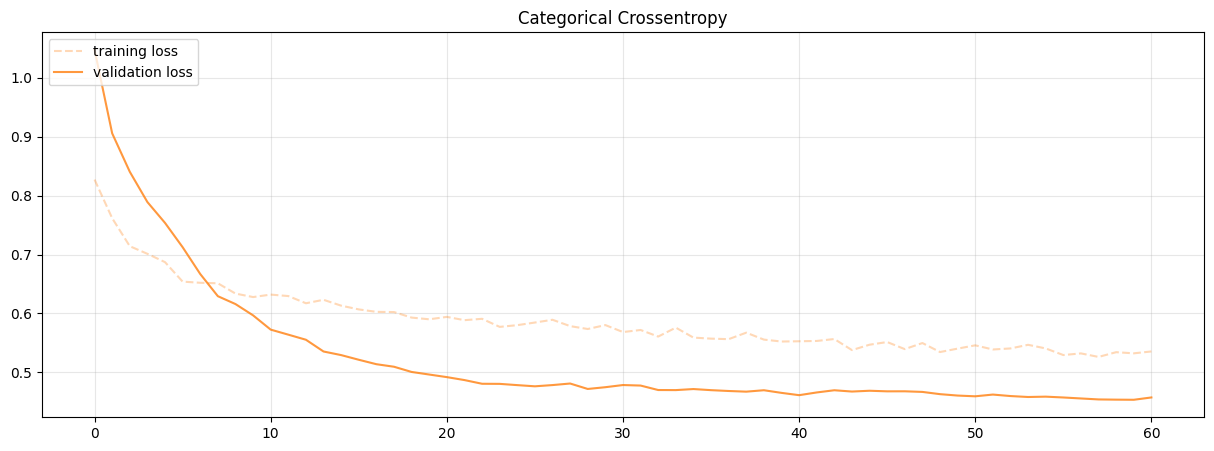

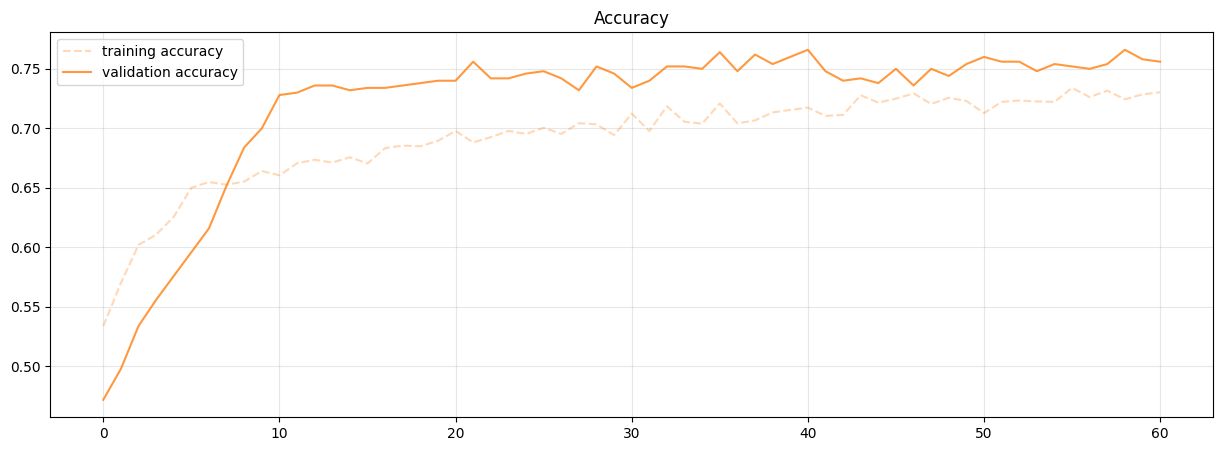

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.7880
0.7879999876022339


In [ ]:
model.save("Sec-Saved-FT125MobileNetV2WithAug")
del model

### MobileNetV2 with all parameters being untrainable

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

In [ ]:
# # train all the weights
# modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')

# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(process)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# freeze all the weights
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  layer.trainable=False
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_5 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithoutFTWithAugAllOff.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 7s 46ms/step - loss: 0.8897 - accuracy: 0.5052 - precision_4: 0.5052 - recall_4: 0.5052 - f1_score: 0.5044 - val_loss: 0.7739 - val_accuracy: 0.5540 - val_precision_4: 0.5540 - val_recall_4: 0.5540 - val_f1_score: 0.5540
Epoch 2/200
82/82 [==============================] - 3s 32ms/step - loss: 0.8634 - accuracy: 0.5117 - precision_4: 0.5117 - recall_4: 0.5117 - f1_score: 0.5117 - val_loss: 0.7588 - val_accuracy: 0.5560 - val_precision_4: 0.5560 - val_recall_4: 0.5560 - val_f1_score: 0.5560
Epoch 3/200
82/82 [==============================] - 3s 34ms/step - loss: 0.8431 - accuracy: 0.5190 - precision_4: 0.5190 - recall_4: 0.5190 - f1_score: 0.5190 - val_loss: 0.7461 - val_accuracy: 0.5500 - val_precision_4: 0.5500 - val_recall_4: 0.5500 - val_f1_score: 0.5500
Epoch 4/200
82/82 [==============================] - 3s 34ms/step - loss: 0.8207 - accuracy: 0.5238 - precision_4: 0.5238 - recall_4: 0.5238 - f1_score: 0.5238 - val_loss: 0.7363

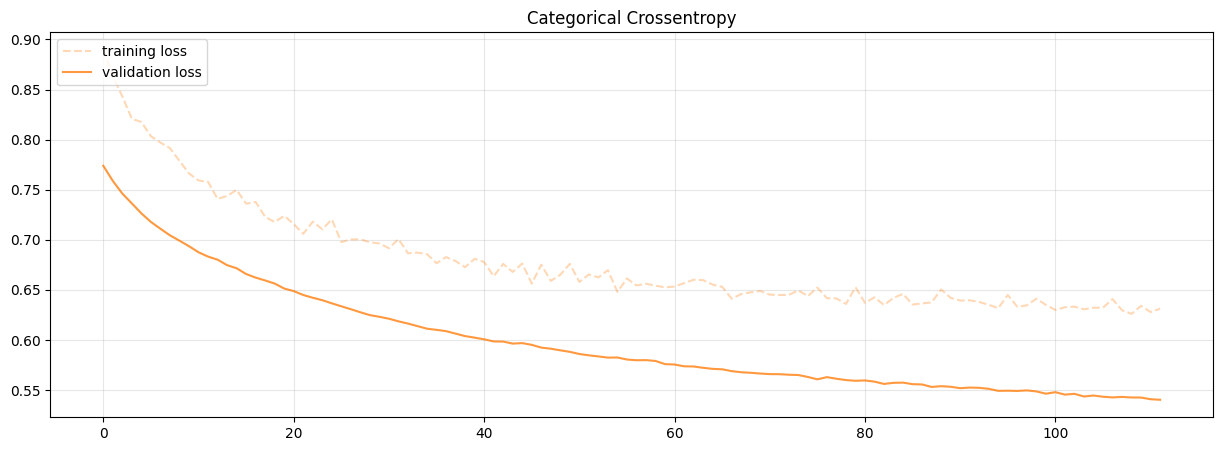

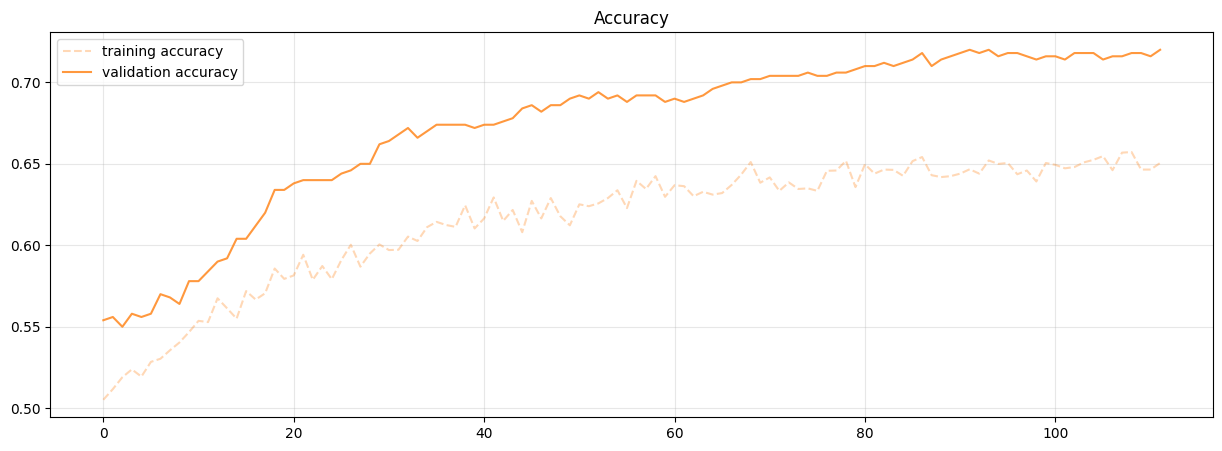

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.7460
0.7459999918937683


In [ ]:
model.save("Sec-Saved-NoFT116MobileNetV2WithAugAllOff")
del model

### MobileNetV2 with all parameters being trainable

In [ ]:
modelObj = tf.keras.applications.MobileNetV2(
            # discard the fully connected layer at the end
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=(96, 96, 3),
            pooling="avg"
)

# # model architecture
# tfk.utils.plot_model(modelObj, show_shapes=True)

In [ ]:
# train all the weights
modelObj.trainable = True

# data augmentation - each input pic will apply one of the 5 transformations
preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("horizontal", name = "RandomFlip_horizontal"),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2)
    ], name='preprocessing')

# input layer
inputs = tfk.Input(shape = input_shape, name = "input")

# augmentation
augmentation = preprocessing(inputs)

# model
process = modelObj(augmentation)

# output layer
outputs = tfkl.Dense(units = 2,
                     activation = "softmax",
                     name = "output")(process)

# create the model
model = tfk.Model(inputs = inputs, outputs = outputs, name = "MobileNetV2")

In [ ]:
# unfreeze all the weights
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
  print(i, layer.name, layer.trainable)

# compile the model
model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()])

# model summary
model.summary()

0 input_6 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [ ]:
# train the model
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    # mode = "max", the higher validation accuracy the better
    # when validation accuracy gets lower or plateaus for more than 20 epochs, stop training
    callbacks = [tfk.callbacks.CSVLogger('Sec-Saved-MobileNetV2WithoutFTWithAugAllOn.csv', append=True),
                 tfk.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True)]
).history

Epoch 1/200
82/82 [==============================] - 31s 99ms/step - loss: 0.8694 - accuracy: 0.5023 - precision_5: 0.5023 - recall_5: 0.5023 - f1_score: 0.4998 - val_loss: 0.7752 - val_accuracy: 0.5280 - val_precision_5: 0.5280 - val_recall_5: 0.5280 - val_f1_score: 0.5265
Epoch 2/200
82/82 [==============================] - 6s 71ms/step - loss: 0.7600 - accuracy: 0.5611 - precision_5: 0.5611 - recall_5: 0.5611 - f1_score: 0.5611 - val_loss: 0.7376 - val_accuracy: 0.5800 - val_precision_5: 0.5800 - val_recall_5: 0.5800 - val_f1_score: 0.5734
Epoch 3/200
82/82 [==============================] - 6s 75ms/step - loss: 0.7271 - accuracy: 0.5975 - precision_5: 0.5975 - recall_5: 0.5975 - f1_score: 0.5975 - val_loss: 0.7295 - val_accuracy: 0.5980 - val_precision_5: 0.5980 - val_recall_5: 0.5980 - val_f1_score: 0.5848
Epoch 4/200
82/82 [==============================] - 6s 76ms/step - loss: 0.6996 - accuracy: 0.6157 - precision_5: 0.6157 - recall_5: 0.6157 - f1_score: 0.6157 - val_loss: 0.712

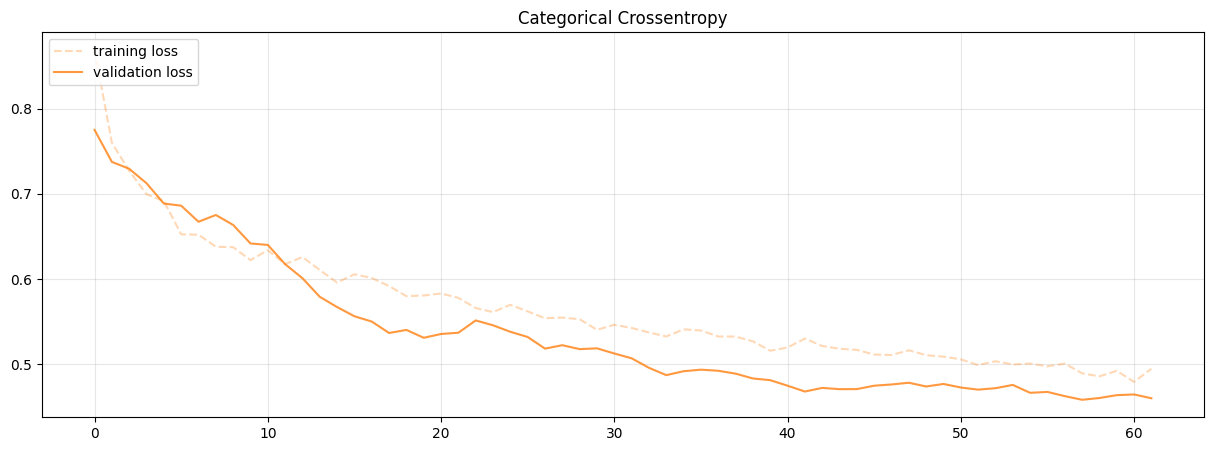

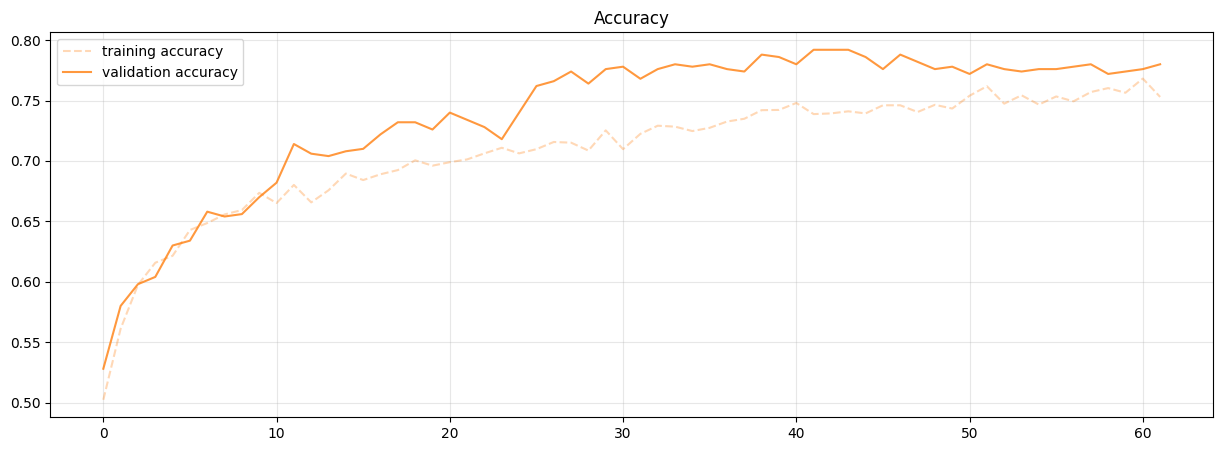

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, label = "training loss", color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label = "validation loss", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = "training accuracy", alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label = "validation accuracy", alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate on the test set
test_acc = model.evaluate(preprocess_input(X_test), y_test, verbose=0)[1]
print("Test set accuracy is %.4f"% test_acc)
# the first one is loss
# the second one is accuracy
# the third one is precision
# the fourth one is recall
# the fifth one is an array with F1 of class 0 and class 1
print(test_acc)

Test set accuracy is 0.7920
0.7919999957084656


In [ ]:
model.save("Sec-Saved-NoFTMobileNetV2WithAugAllOn")
del model

## Summary comparison plots

In [ ]:
fileNames = ["Sec-Saved-MobileNetV2WithFT116WithAug.csv",
             "Sec-Saved-MobileNetV2WithFT116WithAugWith2Dense.csv",
             "Sec-Saved-MobileNetV2WithFT125WithAug.csv",
             "Sec-Saved-MobileNetV2WithFT125WithAugWith1Dense.csv",
             "Sec-Saved-MobileNetV2WithFT125WithAugWith2Dense.csv",
             "Sec-Saved-MobileNetV2WithoutFTWithAugAllOff.csv",
             "Sec-Saved-MobileNetV2WithoutFTWithAugAllOn.csv"]

labelNames = ["Start from 116th layer",
              "Start from 116th layer(with 2 Dense & 2 BN & 2 Dropout)",
              "Start from 125th layer",
              "Start from 125th layer(with 1 Dense & 1 BN & 1 Dropout)",
              "Start from 125th layer(with 2 Dense & 2 BN & 2 Dropout)",
              "All untrainable",
              "All trainable"]

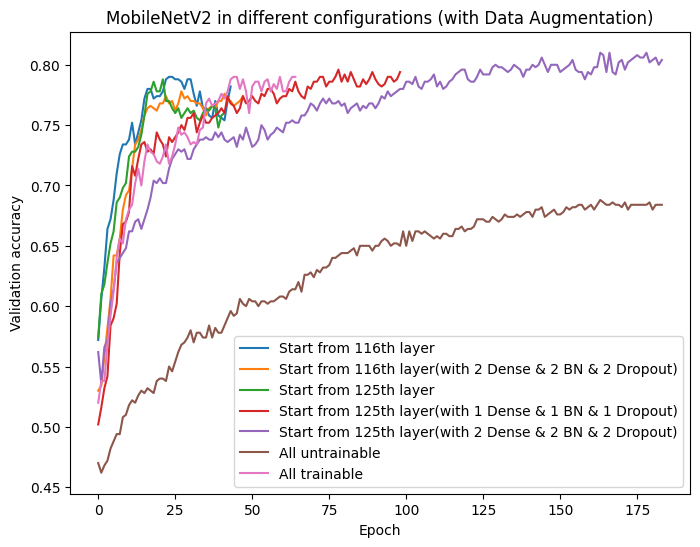

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
for inx, files in enumerate(fileNames):
  df = pd.read_csv(files)
  val_acc = df[["val_accuracy"]]
  ax.plot(val_acc, label = labelNames[inx])

ax.set_title("MobileNetV2 in different configurations (with Data Augmentation)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation accuracy")
plt.legend()
plt.show()